In [1]:
# libraries
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## 1. The Dataset: Adult Income Data

#### The Adult Income dataset is a classification dataset: it is used for a prediction task where the goal is to determine whether a person makes over 50k a year. The list of attributes is as follows:
- output variable: **Income**, <=50k and >50k (converted to 0 and 1 respectively)
- input features: 
    - **Age**: a continuous number
    - **WorkClass**: a categorical variable that represents different work sectors, including values such as Federal employee, Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked, Federal worker
    - **Education**: a categorical variable that represents the level of education, including values such as Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
    - **MaritalStatus**: a categorical variable with values Married-civ-spouse (Married to a civilian spouse), Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse (Married to someone in the Armed Forces) 
    - **Occupation**: a categorical variable with values Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
    - **EducationNum**: a continuous value that represents the level of education (0 = Preschool, 16 = Doctorate)
    - **Race**: a categorical variable with values White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black 
    - **Gender**: a binary variable, includes Female and Male
    - **CapitalGain**: a continuous number
    - **CapitalLoss**: a continuous number
    - **HoursPerWeek**: a categorical variable including hour ranges of 0-30, 30-60, 60-90, 90+
    - **NativeCountry**: a categorical variable including countries such as United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands

In [3]:
df = pd.read_csv("Data/income_training_updated.csv")

df.columns = [
        "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
        "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]

def convert_hours(x):
    if x < 30:
        return "0-30"
    elif x < 60:
        return "30-60"
    elif x < 90:
        return "60-90"
    else:
        return "90+"

df['HoursPerWeek'] = df['HoursPerWeek'].apply(lambda x: convert_hours(x))

cols = [
        "Age", "WorkClass", "Education","EducationNum", "MaritalStatus", "Occupation", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]
df = df[cols]


train_cols = df.columns[0:-1]
label = df.columns[-1]
X_df = df[train_cols]
y_df = df[label]

X_display = X_df.copy()

#Converting strings to integers and floats for categorical data
categorical_cols = ["WorkClass", "Education", "MaritalStatus", "Occupation", "Race", "Gender", "NativeCountry", "HoursPerWeek"]

for col in categorical_cols:
    X_df[col] = pd.Categorical(X_df[col])
    X_df[col] = X_df[col].cat.codes


#Converting the response / output variable to a binary class
y_df = y_df.apply(lambda x: 0 if x == "<=50K" else 1)


#Top 5 rows of the original dataset:
df.head()

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,White,Male,0,0,30-60,United-States,>50K
1,31,Private,Masters,14,Never-married,Prof-specialty,White,Female,14084,0,30-60,United-States,>50K
2,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,White,Male,5178,0,30-60,United-States,>50K
3,37,Private,Some-college,10,Married-civ-spouse,Exec-managerial,Black,Male,0,0,60-90,United-States,>50K
4,30,State-gov,Bachelors,13,Married-civ-spouse,Prof-specialty,Asian-Pac-Islander,Male,0,0,30-60,India,>50K


In [4]:
df = pd.read_csv("Data/income_test_orig.csv")

df.columns = [
        "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
        "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]

def convert_hours(x):
    if x < 30:
        return "0-30"
    elif x < 60:
        return "30-60"
    elif x < 90:
        return "60-90"
    else:
        return "90+"

df['HoursPerWeek'] = df['HoursPerWeek'].apply(lambda x: convert_hours(x))

cols = [
        "Age", "WorkClass", "Education","EducationNum", "MaritalStatus", "Occupation", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]
df = df[cols]


train_cols = df.columns[0:-1]
label = df.columns[-1]
test_X_df = df[train_cols]
test_y_df = df[label]


#Converting strings to integers and floats for categorical data
categorical_cols = ["WorkClass", "Education", "MaritalStatus", "Occupation", "Race", "Gender", "NativeCountry", "HoursPerWeek"]

for col in categorical_cols:
    test_X_df[col] = pd.Categorical(test_X_df[col])
    test_X_df[col] = test_X_df[col].cat.codes


#Converting the response / output variable to a binary class
test_y_df = test_y_df.apply(lambda x: 0 if x == "<=50K" else 1)


#Top 5 rows of the original dataset:
df.head()

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Black,Male,0,0,30-60,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,White,Male,0,0,30-60,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,White,Male,0,0,30-60,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Black,Male,7688,0,30-60,United-States,>50K
4,18,?,Some-college,10,Never-married,?,White,Female,0,0,30-60,United-States,<=50K


## 2. The Model: LightGBM

In [5]:
d_train = lgb.Dataset(X_df, label=y_df)
d_test = lgb.Dataset(test_X_df, label=test_y_df)

# train a lightgbm for the training dataset
model = lgb.train({}, d_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 32561, number of used features: 12
[LightGBM] [Info] Start training from score 0.240810


In [6]:
#Training accuracy
train_pred = model.predict(X_df).tolist()
train_pred = [0 if x<=0.5 else 1 for x in train_pred]
accuracy_train = round(sum(train_pred == y_df) / len(train_pred), 5)

#Test set accuracy
predictions = model.predict(test_X_df).tolist()
predictions = [0 if x <= 0.5 else 1 for x in predictions]

accuracy_test = round(sum(predictions == test_y_df) / len(predictions), 5)

print("The accuracy of the model on the training set is: ", accuracy_train)
print("The accuracy of the model on the test set is: ", accuracy_test)

indices = [index for index, value in enumerate(zip(predictions, test_y_df.tolist())) if value[0] != value[1]]
shuffle(indices)

The accuracy of the model on the training set is:  0.8832
The accuracy of the model on the test set is:  0.87003


### Visualize Global Explanations: What the model learned overall from training data

In [7]:
# Global feature importance values
importance_df = (
    pd.DataFrame({
        'feature_name': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)
print(importance_df)

     feature_name  importance
0             Age         676
1     CapitalLoss         395
2     CapitalGain         374
3      Occupation         366
4    EducationNum         309
5   MaritalStatus         248
6       WorkClass         159
7       Education         147
8    HoursPerWeek         103
9   NativeCountry          92
10         Gender          75
11           Race          56


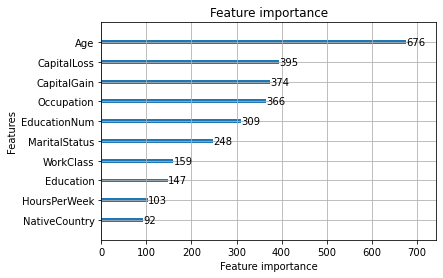

In [8]:
# Global feature importance chart
ax = lgb.plot_importance(model, max_num_features=10)
plt.show()

### Visualize Global Explanations for Specific Input Features: What the model learned about a feature from the training data

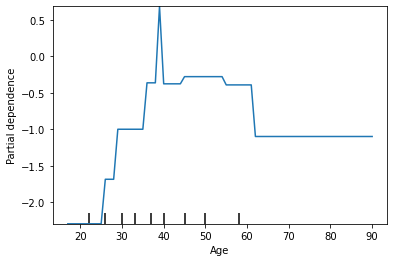

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
      max_depth=1, random_state=0).fit(X_df, y_df)
features = ["Age"]
PartialDependenceDisplay.from_estimator(clf, X_df, features)

In [10]:
# The raw values can be found below
from sklearn.inspection import partial_dependence

results = partial_dependence(clf, X_df, ["Age"])

# results["values"]
results["average"]

TypeError: tuple indices must be integers or slices, not str